# Get ths cis effects

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
sys.path.append('/Users/hannahboekweg/WhenMutationsDontMatter')
import plot_utils as p

/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
endo = cptac.Endometrial()

In [3]:
gene = 'PIK3CA'

In [4]:
prot_and_mutations = endo.get_genotype_all_vars(gene)

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 48 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 382)


In [5]:
prot_and_mutations['Mutation'].unique()

array(['Missense_Mutation', 'Wildtype_Tumor', 'Amplification',
       'Frame_Shift_Ins', 'In_Frame_Del', 'Deletion'], dtype=object)

In [6]:
keep = ['Missense_Mutation','Wildtype_Tumor']
in_keep = prot_and_mutations['Mutation'].isin(keep)
miss_mutations = prot_and_mutations[in_keep]

In [7]:
#Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
columns_to_drop = ["Location", "Mutation_Status"]
mut_status = miss_mutations.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
mut_status['Mutation'].value_counts()

Missense_Mutation    43
Wildtype_Tumor       41
Name: Mutation, dtype: int64

In [8]:
#join proteomics
proteomics = endo.get_proteomics()
proteomics = proteomics[["PIK3CA"]]#get just PIK3CA
proteomics = proteomics[~proteomics.index.str.contains(".N")] #get rid of normal samples

proteomics["Mutation"] = mut_status['Mutation']
proteomics = proteomics.dropna()


In [9]:
mut_status = proteomics
mut_status[gene+"_proteomics"] = proteomics["PIK3CA"]
mut_status['binary_mutations'] = proteomics["Mutation"]
mut_status = mut_status.drop(columns=["PIK3CA", "Mutation"])

In [10]:
help(u.wrap_ttest)

Help on function wrap_ttest in module cptac.utils:

wrap_ttest(df, label_column, comparison_columns=None, alpha=0.05, return_all=False, correction_method='bonferroni')



In [11]:
u.wrap_ttest(mut_status, 'binary_mutations', ['PIK3CA_proteomics'], return_all=True)

,Comparison,P_Value
0,PIK3CA_proteomics,0.109686


In [12]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")



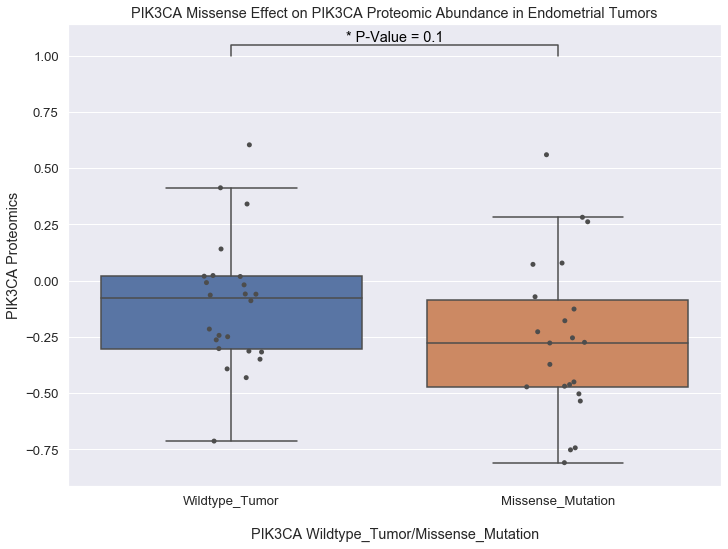

In [25]:
#cis
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='binary_mutations', y=gene+"_proteomics", 
                         order = ['Wildtype_Tumor', 'Missense_Mutation'], data = mut_status, showfliers = False)    
boxplot.set_title('PIK3CA Missense Effect on '+gene+' Proteomic Abundance in Endometrial Tumors')
boxplot = sns.stripplot(x='binary_mutations', y=gene+"_proteomics", data = mut_status, jitter = True, 
                           color = ".3", order = ['Wildtype_Tumor', 'Missense_Mutation'], dodge = True)
boxplot.set(xlabel = "\nPIK3CA Wildtype_Tumor/Missense_Mutation", ylabel = gene+' Proteomics')

format_pval_annotation('* P-Value = 0.1', 0, 1, 1)

plt.show()
plt.clf()
plt.close()

# Trans

In [24]:
ip = u.get_interacting_proteins('PIK3CA')
list(ip)

['PIK3R2',
 'TNS1',
 'RPS6KB1',
 'KRAS',
 'PDGFRA',
 'PIK3R3',
 'AKT3',
 'PIK3CA',
 'ERBB3',
 'IGF1R',
 'ERBB2',
 'EGFR',
 'GNAQ',
 'KIT',
 'MRAS',
 'IRS1',
 'CTNNB1',
 'NRAS',
 'PTEN',
 'IRS2',
 'AKT2',
 'CDC42',
 'ESR1',
 'HRAS',
 'PIK3R1',
 'AKT1',
 'ATR',
 'LCK',
 'NOTCH1',
 'ADAP1',
 'DGKZ',
 'ARHGEF1',
 'GSN',
 'YWHAH',
 'IRS4',
 'UBTF']

# This is from the meeting

get the missense mutation hotspots
abunance who have a mutation vs the wildtype (these are our two buckets)
for every gene do a t test
start with PIK3ca and go through every gene
Hotspot:
E542K
E535K
H1047R

In [15]:
import cptac

In [16]:
en = cptac.Endometrial()

In [17]:
col = cptac.Colon()

In [26]:
help(en.get_genotype_all_vars)

Help on method get_genotype_all_vars in module cptac.dataset:

get_genotype_all_vars(mutations_genes, mutations_filter=None, show_location=True, mutation_hotspot=None) method of cptac.endometrial.Endometrial instance
    Return a dataframe that has the mutation type and wheather or not it is a multiple mutation
    Parameters:
    mutation_genes (str, or list or array-like of str): The gene(s) to get mutation data for.
    mutations_filter (list, optional):  List of mutations to prioritize when filtering out multiple mutations, in order of priority.
    show_location (bool, optional): Whether to include the Location column from the mutation dataframe. Defaults to True.
    mutation_hotspot (optional): a list of hotspots



In [35]:
endoh = en.get_genotype_all_vars("PIK3CA", mutation_hotspot=["H1047R", 'E542K', 'E535K'])


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 48 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 382)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 48 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 382)


In [36]:
missenseh = endoh.loc[endoh['Mutation'] == "Missense_Mutation"]

In [37]:
#pull out all the missense mutation
missense = endo.loc[endo['Mutation'] == "Missense_Mutation"]
# E542K
# E535K
# H1047R
# missense

In [38]:
missense['Location'].equals(missenseh['Location'])

True

In [19]:
colon = col.get_genotype_all_vars("PIK3CA")

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 382)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 382)


In [20]:
missense_colcon = colon.loc[colon['Mutation'] == "nonsynonymous SNV"]
missense_colcon

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
01CO022,nonsynonymous SNV,Q981R,Single_mutation
05CO003,nonsynonymous SNV,C420R,Multiple_mutation
05CO006,nonsynonymous SNV,E103G,Single_mutation
05CO028,nonsynonymous SNV,E545K,Single_mutation
05CO032,nonsynonymous SNV,H1047R,Single_mutation
05CO050,nonsynonymous SNV,E85G,Single_mutation
09CO005,nonsynonymous SNV,H1047R,Single_mutation
11CO018,nonsynonymous SNV,R108H,Single_mutation
11CO027,nonsynonymous SNV,E545K,Single_mutation
